In [44]:
import pandas as pd
import prophet
import matplotlib.pyplot as plt

# Prophet de Meta



## ¿Qué es Prophet? El Enfoque Aditivo

Prophet es una librería de código abierto de **Meta (Facebook)**, creada para generar **predicciones de series de tiempo** de alta calidad, especialmente para datos que tienen fuertes patrones estacionales y efectos de días festivos.

###  Series de Tiempo

Una **Serie de Tiempo** es simplemente una secuencia de puntos de datos indexados (o listados) en orden cronológico, por ejemplo: las ventas diarias, el tráfico web por hora, o la temperatura anual.

Prophet es un modelo que se clasifica típicamente como una técnica de **aprendizaje supervisado** (o *regresión*), ya que utiliza datos históricos (`ds` o tiempo) para aprender la relación con el valor objetivo (`y`) y luego predice ese valor futuro.

### El Modelo Aditivo: Modularidad y Simplicidad

Su principal fortaleza es que se basa en un **modelo aditivo** que es altamente **interpretable**.

* **Aditivo** significa que la predicción final es la **suma** de partes separadas. Es decir, descompone la serie de tiempo en componentes que se modelan independientemente.





## 💡 El Corazón de Prophet: La Intuición del Modelo Aditivo

Prophet no es un modelo complejo de "caja negra"; es como un **rompecabezas modular**. En lugar de predecir todo de una vez, descompone la serie de tiempo en **tres partes simples** y fáciles de entender, y luego las suma.

Imagina que tu serie de tiempo son tus **ventas diarias**. Prophet dice: "Tu venta total en el tiempo ($\hat{y}(t)$) es la suma de:"

$$\hat{y}(t) = g(t) + s(t) + h(t) + \epsilon_t$$

$$\hat{y}(t) = \text{Tendencia} + \text{Estacionalidad} + \text{Días Festivos} + \text{Error}$$

La clave de Prophet es esta **estructura modular**. Al modelar cada componente ($\mathbf{g(t)}$, $\mathbf{s(t)}$, $\mathbf{h(t)}$) por separado, podemos entender **exactamente por qué** la predicción sube o baja en cualquier momento.





## 📈 Componente 1: La Tendencia ($g(t)$)

La **Tendencia ($g(t)$)** captura el **crecimiento o decrecimiento a largo plazo**. Piensa en la popularidad general de tu producto o en el estado de la economía.

### ¿Cómo lo modela Prophet?

Prophet utiliza una línea recta **a trozos** (*piecewise*). Es decir, la tasa de crecimiento puede **cambiar abruptamente** en momentos específicos, llamados **Puntos de Cambio** (*Changepoints*).

  * **Intuición:** El modelo se adapta a eventos históricos que alteraron el crecimiento, como un cambio de política o el lanzamiento de un competidor. Prophet detecta estos cambios automáticamente.
  * **Modelo Logístico (Opcional):** Si sabemos que el crecimiento tiene un **límite máximo conocido** (por ejemplo, la capacidad de un mercado), Prophet puede usar una curva que se **aplana** a medida que se acerca a ese límite, en lugar de crecer sin parar.







## ☀️ Componente 2: La Estacionalidad ($s(t)$)

La **Estacionalidad ($s(t)$)** modela los **patrones regulares que se repiten** a lo largo del tiempo.

  * **Ejemplos:** Las ventas suben todos los lunes (patrón semanal) o las ventas de un producto suben siempre en diciembre (patrón anual).

### ¿Cómo lo modela Prophet?

Prophet usa **Series de Fourier** (una combinación de funciones de seno y coseno).

  * **Intuición:** Esto es como un **ecualizador de sonido**. Al mezclar ondas suaves de diferentes frecuencias, Prophet puede recrear la **forma exacta** de tu patrón repetitivo (semanal o anual), incluso si es complejo, sin tener que asumir una forma rígida.
 




## 🗓️ Componente 3: Días Festivos y Eventos ($h(t)$)

El componente **Días Festivos ($h(t)$)** es un **ajuste manual** para capturar el impacto conocido de eventos **irregulares**, que no son parte del ciclo normal semanal o anual.

  * **Ejemplo:** Black Friday, un evento deportivo único, o un día de huelga.
  * **Funcionamiento:** Se trata de una variable *dummy* (un indicador binario 0/1). Si la fecha $t$ coincide con un día festivo, el modelo aplica un **efecto adicional** (positivo o negativo) a la predicción.


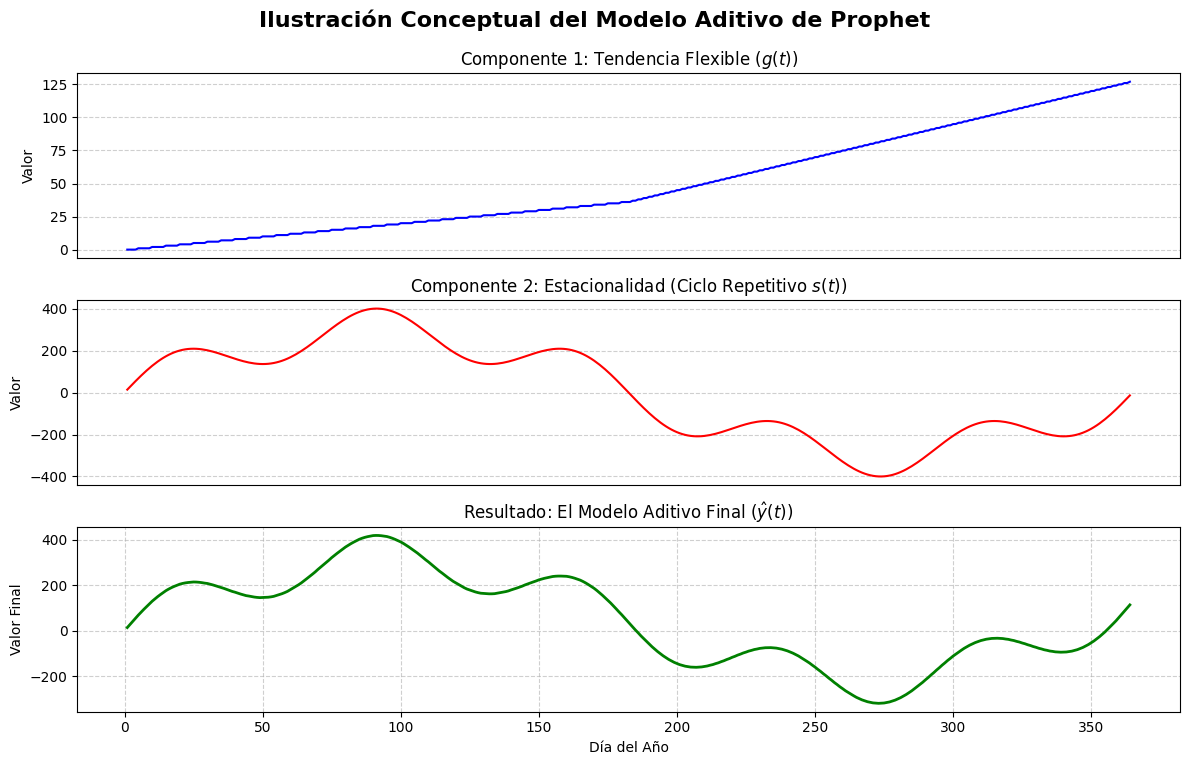

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1. Crear el eje de tiempo (52 semanas o 1 año conceptual)
dias = np.arange(1, 365)
tiempo = dias / 365 # Normalizado para fines de la gráfica

# 2. Componente g(t): Tendencia (Un crecimiento lineal con un "punto de cambio" a mitad de año)
# Simulamos una tendencia que aumenta su inclinación a mitad de año
g_t = np.piecewise(dias, [dias < 182, dias >= 182], 
                   [lambda x: 0.2 * x, lambda x: 0.2 * 182 + 0.5 * (x - 182)])

# 3. Componente s(t): Estacionalidad (Un patrón anual de ondas)
s_t = 300 * np.sin(2 * np.pi * tiempo * 1) + 100 * np.sin(2 * np.pi * tiempo * 5)

# 4. Predicción (y_hat): La suma de los componentes
y_hat = g_t + s_t

# 5. Generar la Gráfica de Descomposición

plt.figure(figsize=(12, 8))

# Gráfica 1: Tendencia (g(t))
plt.subplot(3, 1, 1)
plt.plot(dias, g_t, label='Tendencia $g(t)$', color='blue')
plt.title('Componente 1: Tendencia Flexible ($g(t)$)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylabel('Valor')
plt.xticks([]) # Ocultar etiquetas X para mantener la limpieza

# Gráfica 2: Estacionalidad (s(t))
plt.subplot(3, 1, 2)
plt.plot(dias, s_t, label='Estacionalidad $s(t)$', color='red')
plt.title('Componente 2: Estacionalidad (Ciclo Repetitivo $s(t)$)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylabel('Valor')
plt.xticks([]) # Ocultar etiquetas X para mantener la limpieza

# Gráfica 3: Predicción (g(t) + s(t))
plt.subplot(3, 1, 3)
plt.plot(dias, y_hat, label='Predicción $\hat{y}(t) = g(t) + s(t)$', color='green', linewidth=2)
plt.title('Resultado: El Modelo Aditivo Final ($\hat{y}(t)$)')
plt.xlabel('Día del Año')
plt.ylabel('Valor Final')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Ilustración Conceptual del Modelo Aditivo de Prophet', fontsize=16, fontweight='bold')
plt.show()


> 1.  Crea una **Tendencia ($g(t)$)** (arriba) que maneja el crecimiento a largo plazo y se ajusta a cambios importantes (*puntos de cambio*).
> 2.  Añade una **Estacionalidad ($s(t)$)** (en medio) que captura los ciclos repetitivos (como el invierno o el verano) usando ondas suaves de Fourier.
> 3.  Al **sumar** estos dos componentes (junto con el efecto de días festivos que no se muestra), obtenemos la **Predicción Final ($\hat{y}(t)$)** (abajo), la cual es mucho más rica y precisa que si solo usáramos una línea recta."



# Ejemplo Practico

## Libreria de Prophet Forecasting 

In [46]:
# check prophet version
import prophet
# print version number
print('Prophet %s' % prophet.__version__)

Prophet 1.1.7


In [47]:
# load the car sales dataset
from pandas import read_csv
# load data
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
df = read_csv(path, header=0)
# summarize shape
print(df.shape)
# show first few rows
print(df.head())

(108, 2)
     Month  Sales
0  1960-01   6550
1  1960-02   8728
2  1960-03  12026
3  1960-04  14395
4  1960-05  14587


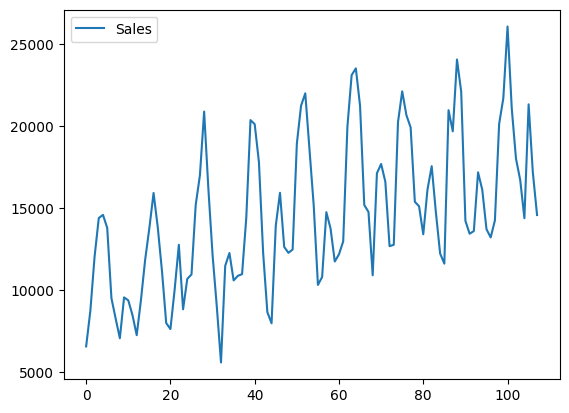

KeyError: 'y'

In [ ]:
# load and plot the car sales dataset
from pandas import read_csv
from matplotlib import pyplot
# load data
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
df = read_csv(path, header=0)
# plot the time series
df.plot()
pyplot.show()



00:17:24 - cmdstanpy - INFO - Chain [1] start processing
00:17:24 - cmdstanpy - INFO - Chain [1] done processing


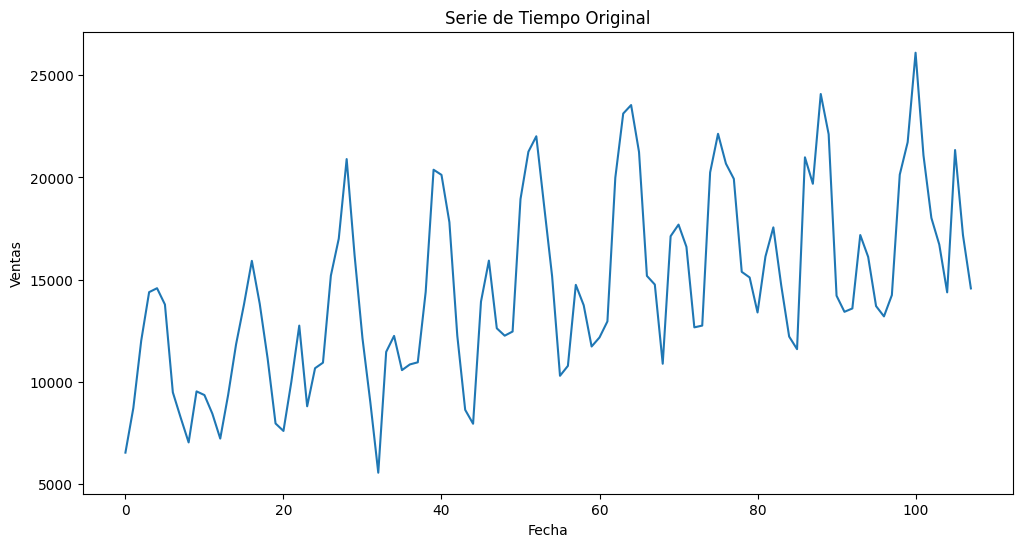

In [ ]:
# fit prophet model on the car sales dataset
from pandas import read_csv
from pandas import to_datetime
from prophet import Prophet
import pandas as pd
from pandas import DataFrame, to_datetime


# load data
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
df = read_csv(path, header=0)
# prepare expected column names
df.columns = ['ds', 'y']
df['ds']= to_datetime(df['ds'])
# define the model
model = Prophet()
# fit the model
model.fit(df)


In [50]:
# define the period for which we want a prediction
future = list()
for i in range(1, 13):
	date = '1968-%02d' % i
	future.append([date])
future = DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])
forecast = model.predict(future)

          ds          yhat    yhat_lower    yhat_upper
0 1968-01-01  14365.838146  12767.229754  15964.833206
1 1968-02-01  14940.305749  13407.192239  16526.021135
2 1968-03-01  20882.028850  19188.316673  22319.634981
3 1968-04-01  22900.416536  21297.898339  24499.719385
4 1968-05-01  24201.080202  22739.229388  25805.839402


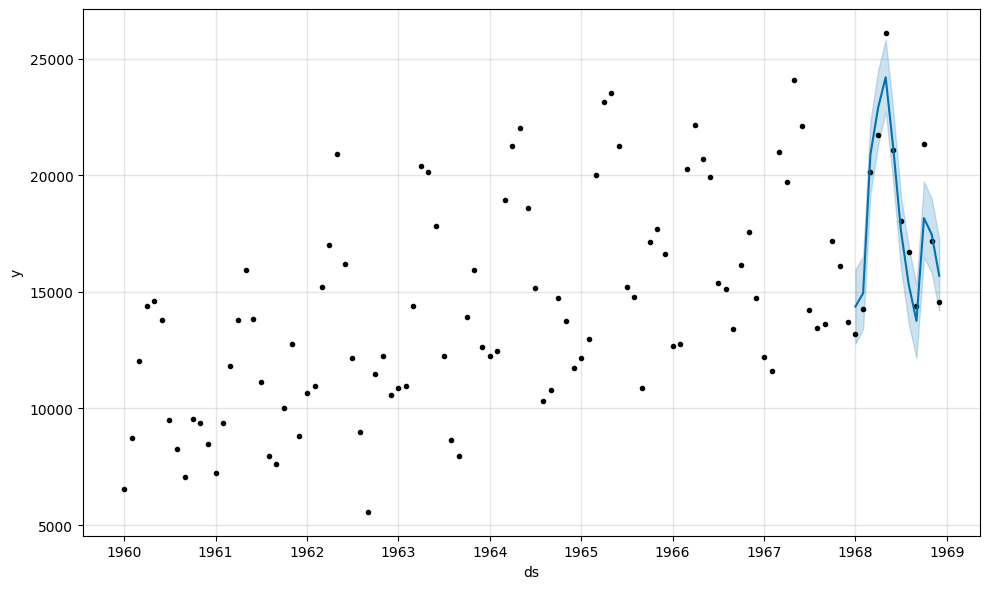

In [51]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
pyplot.show()

## Out-of-Sample Forecast

In [52]:
# define the period for which we want a prediction
future = list()
for i in range(1, 13):
	date = '1969-%02d' % i
	future.append([date])
future = DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])

00:14:08 - cmdstanpy - INFO - Chain [1] start processing
00:14:08 - cmdstanpy - INFO - Chain [1] done processing


          ds          yhat    yhat_lower    yhat_upper
0 1969-01-01  15414.370948  13808.182548  16970.309472
1 1969-02-01  16182.031762  14662.549363  17807.551890
2 1969-03-01  21399.275915  19855.623988  23047.554697
3 1969-04-01  23514.723288  21947.846693  25036.586416
4 1969-05-01  25020.049095  23300.768369  26628.293405


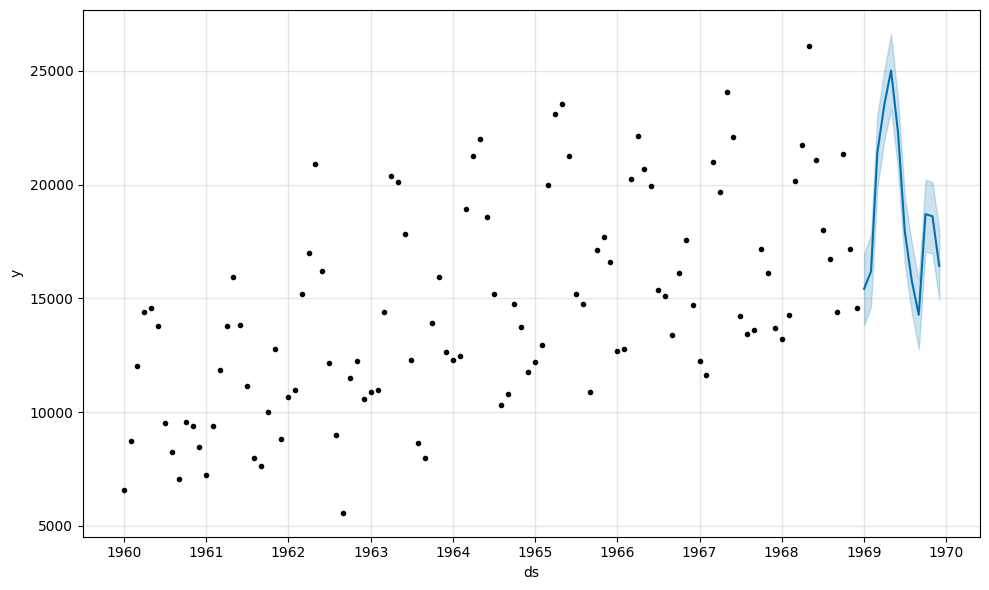

In [53]:

df.columns = ['ds', 'y']
df['ds']= to_datetime(df['ds'])
# define the model
model = Prophet()
# fit the model
model.fit(df)
# define the period for which we want a prediction
future = list()
for i in range(1, 13):
	date = '1969-%02d' % i
	future.append([date])
future = DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
pyplot.show()

## Evaluar el modelo manualmente

00:14:08 - cmdstanpy - INFO - Chain [1] start processing
00:14:09 - cmdstanpy - INFO - Chain [1] done processing


MAE: 1336.813


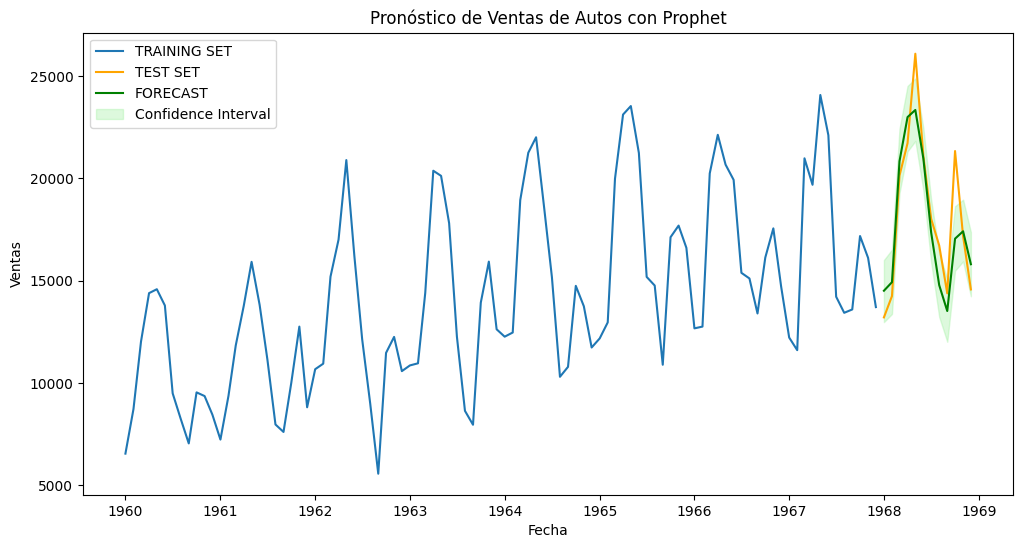

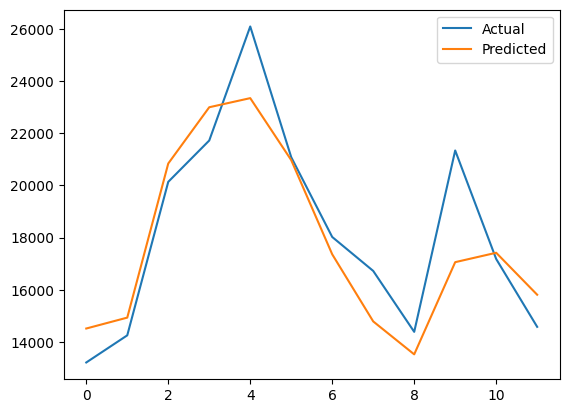

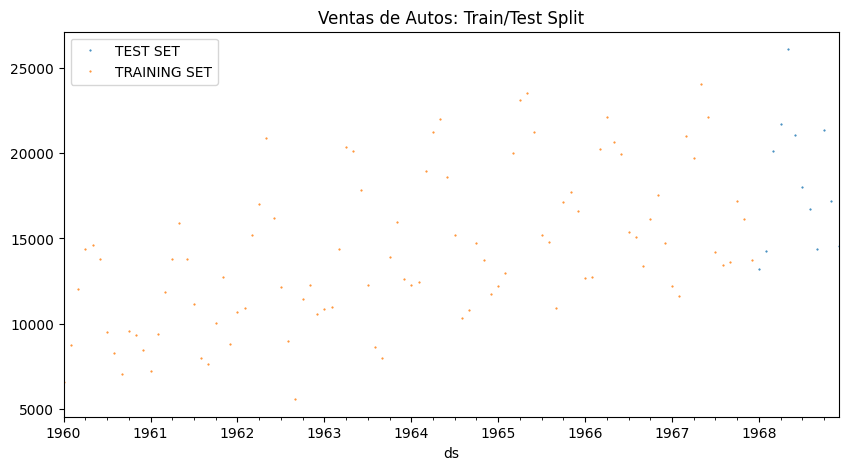

In [54]:
import pandas as pd
from pandas import read_csv, to_datetime, DataFrame
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# ============================================
# Cargar dataset
# ============================================
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
df = read_csv(path, header=0)
df.columns = ['ds', 'y']
df['ds'] = to_datetime(df['ds'])
df.set_index('ds', inplace=True)

# ============================================
# Crear train/test (últimos 12 meses como test)
# ============================================
train = df.drop(df.index[-12:])
test = df.tail(12)  # últimos 12 meses
y_true = test['y'].values  # valores reales del test

# ============================================
# Entrenar Prophet solo con train
# ============================================
train_prophet = train.reset_index()
model = Prophet()
model.fit(train_prophet)

# ============================================
# Predecir sobre el horizonte del test
# ============================================
future = test.reset_index()[['ds']]  # mismo rango que test
forecast = model.predict(future)
y_pred = forecast['yhat'].values  # predicciones

# ============================================
# Calcular MAE
# ============================================
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

# ============================================
# Graficar train, test y forecast
# ============================================
plt.figure(figsize=(12,6))
plt.plot(train.index, train['y'], label='TRAINING SET')
plt.plot(test.index, y_true, label='TEST SET', color='orange')
plt.plot(forecast['ds'], y_pred, label='FORECAST', color='green')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                 color='lightgreen', alpha=0.3, label='Confidence Interval')
plt.title('Pronóstico de Ventas de Autos con Prophet')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()

# plot expected vs actual 
pyplot.plot(y_true, label='Actual') 
pyplot.plot(y_pred, label='Predicted') 
pyplot.legend() 
pyplot.show()

test.rename(columns={'y': 'TEST SET'}) \
    .join(train.rename(columns={'y': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(10, 5), title='Ventas de Autos: Train/Test Split', style='.', ms=1)
plt.show()
